In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP

import types

Using TensorFlow backend.


In [3]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [4]:
pd.set_option('display.max_rows', 2000)

In [5]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [6]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [7]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [8]:
original_columns = df_train.columns.drop(['index','y','label','group']).tolist()

In [14]:
#check feature_importances
df_feature_importances = df_trial.loc[294]['df_feature_importances']
sorted_columns = EP.evaluate(df_feature_importances, key='average_permutation_weight')
# df_feature_importances.sort_values(by=['average_permutation_weight'], ascending=False).head(100)

NameError: name 'df_trial' is not defined

In [ ]:
len(sorted_columns)

In [13]:
# mytrial = []
mytrial = list(pd.read_pickle('../trial/xgbm.pkl').T.to_dict().values())

In [81]:
param={
    'algorithm': {
        'cls': 'xgb.XGBRegressor',
        'fit': {
            'early_stopping_rounds': 200,
            'eval_metric': 'mae',
            'verbose': False
        },
        'init': {
            'colsample_bytree': 0.613634408777225,
            'eta': 0.27673167657779363,
            'max_bin': 78,
            'max_depth': 2,
            'min_child_weight': 537,
            'n_estimators': 330,
            'random_state': 9059,
            'reg_alpha': 0.5314609498047451,
            'reg_lambda': 0.6005341254274578,
            'subsample': 0.6557771570601643,
            'n_jobs':16,
            'random_state': 9950
        }
        },
    'columns': sorted_columns[:120],
    'feature_importance': {
        'is_output': True,
        'permutation_feature_importance': True,
        'permutation_random_state': 1
    },
    'kfold': {
        'n_splits': 8,
        'random_state': 1985,
        'shuffle': True,
        'type': 'timeseries'
    },
    'scaler': {
        'cls': 'StandardScaler'
    }
}

In [73]:
# run one try
df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, param, df_test = df_test, trial=mytrial)

In [82]:
#  select features by permutation_weight
EP.select_features_(df_train, param, mytrial, nfeats_best=20, nfeats_removed_per_try=5, key='average_permutation_weight')

In [103]:
len(columns294)

25

In [196]:
import catboost as cb
cb.CatBoostRegressor?

In [125]:
#  tune hypterparameters
def objective(trial):
        
    max_depth = trial.suggest_int('max_depth', 2, 6)
    max_bin = trial.suggest_int('max_bin', 10, 100)
    eta = trial.suggest_uniform('eta', 0.01, 0.4)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 200, 600)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.000001, 1.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.000001, 1.0)
    random_state = trial.suggest_int('random_state', 1, 9999)
        
    args={
        'columns':columns294,
        'kfold':{
            'n_splits': 8,
            'random_state': 1985,
            'shuffle': True,
            'type': 'stratified'
        },
        'scaler':{
            'cls':'StandardScaler',
        },
        'algorithm':{
            'cls':'xgb.XGBRegressor',
            'init':{
                "max_depth":max_depth,
                "max_bin":max_bin,
                "eta":eta,
                "colsample_bytree":colsample_bytree,
                "min_child_weight":min_child_weight,
                "n_estimators":n_estimators,
                "subsample":subsample,
                "reg_lambda":reg_lambda,
                "reg_alpha":reg_alpha,
                'n_jobs':16
            },
            'fit':{
                'eval_metric':'mae',
                'verbose':False,
                'early_stopping_rounds':200,
            },
        },
        'feature_importance':{
            'is_output':False,
            'permutation_feature_importance':False,
            'permutation_random_state':1,
        },
    }
    
    df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, args, df_test = df_test, trial=mytrial, remark='select feats by timeseries tune by stratified')
    val_mae_mean = np.mean(df_his.valid)
    val_mae_var = np.var(df_his.valid)
    train_mae_mean = np.mean(df_his.train)
    train_mae_var = np.var(df_his.train)
    
    trial.set_user_attr('val_mae', val_mae_mean)
    trial.set_user_attr('train_mae', train_mae_mean)
    trial.set_user_attr('mae_diff', val_mae_mean-train_mae_mean)
    trial.set_user_attr('val_mae_var', val_mae_var)

    return np.abs(val_mae_mean - train_mae_mean)*val_mae_mean

study = optuna.create_study()
study.optimize(objective, n_trials=200)

[I 2019-05-06 11:49:50,376] Finished trial#0 resulted in value: 0.18856980546595234. Current best value is 0.18856980546595234 with parameters: {'max_depth': 5, 'max_bin': 44, 'eta': 0.2817067170209849, 'colsample_bytree': 0.8764871054160122, 'min_child_weight': 533, 'n_estimators': 324, 'subsample': 0.9442847533809089, 'reg_lambda': 0.8727376845584482, 'reg_alpha': 0.18958068120548963, 'random_state': 9559}.
[I 2019-05-06 11:50:06,045] Finished trial#1 resulted in value: 0.15029780061691111. Current best value is 0.15029780061691111 with parameters: {'max_depth': 4, 'max_bin': 50, 'eta': 0.15950950646510217, 'colsample_bytree': 0.8388659697089245, 'min_child_weight': 537, 'n_estimators': 339, 'subsample': 0.7541395741830319, 'reg_lambda': 0.7384743432012523, 'reg_alpha': 0.3698318707149295, 'random_state': 2325}.
[I 2019-05-06 11:50:13,565] Finished trial#2 resulted in value: 0.13581689935820077. Current best value is 0.13581689935820077 with parameters: {'max_depth': 6, 'max_bin': 37

[I 2019-05-06 11:56:11,267] Finished trial#38 resulted in value: 0.22392415455563774. Current best value is 0.04584384612928292 with parameters: {'max_depth': 2, 'max_bin': 22, 'eta': 0.19445391822086788, 'colsample_bytree': 0.8261627828717358, 'min_child_weight': 388, 'n_estimators': 136, 'subsample': 0.7972326413642774, 'reg_lambda': 0.8141070827175308, 'reg_alpha': 0.006372952698758261, 'random_state': 9820}.
[I 2019-05-06 11:56:27,463] Finished trial#39 resulted in value: 0.20546122237001485. Current best value is 0.04584384612928292 with parameters: {'max_depth': 2, 'max_bin': 22, 'eta': 0.19445391822086788, 'colsample_bytree': 0.8261627828717358, 'min_child_weight': 388, 'n_estimators': 136, 'subsample': 0.7972326413642774, 'reg_lambda': 0.8141070827175308, 'reg_alpha': 0.006372952698758261, 'random_state': 9820}.
[I 2019-05-06 11:56:36,986] Finished trial#40 resulted in value: 0.07042077190994335. Current best value is 0.04584384612928292 with parameters: {'max_depth': 2, 'max_b

[I 2019-05-06 12:01:37,028] Finished trial#76 resulted in value: 0.04556663980468782. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:01:41,057] Finished trial#77 resulted in value: 0.06669372563127428. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:01:47,414] Finished trial#78 resulted in value: 0.08937425644240114. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bi

[I 2019-05-06 12:06:38,726] Finished trial#114 resulted in value: 0.12198304445977265. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:06:42,215] Finished trial#115 resulted in value: 0.04352096711425321. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:06:50,563] Finished trial#116 resulted in value: 0.17580422241108523. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max

[I 2019-05-06 12:10:58,527] Finished trial#152 resulted in value: 0.047901780217232966. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:11:01,790] Finished trial#153 resulted in value: 0.039299553553942455. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:11:06,734] Finished trial#154 resulted in value: 0.0657872123220747. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'ma

[I 2019-05-06 12:15:05,848] Finished trial#190 resulted in value: 0.10568436094996814. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:15:13,283] Finished trial#191 resulted in value: 0.07102188888877949. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max_bin': 80, 'eta': 0.012588715486982954, 'colsample_bytree': 0.657671182452515, 'min_child_weight': 405, 'n_estimators': 100, 'subsample': 0.8405446747895091, 'reg_lambda': 0.9201007794197412, 'reg_alpha': 0.8191310008309961, 'random_state': 9124}.
[I 2019-05-06 12:15:21,924] Finished trial#192 resulted in value: 0.09484069590089791. Current best value is 0.038054441941153615 with parameters: {'max_depth': 2, 'max

In [15]:
df_trial = pd.DataFrame(mytrial)
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])

In [121]:
df_trial.loc[294][['datetime','kfold-type', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

datetime         2019-05-06 07:12:30.231319
kfold-type                       timeseries
nfeatures                                25
train_mae                           2.18629
train_mae_var                       0.12777
val_mae                             1.98181
val_mae_var                        0.701263
mae_diff                          -0.204486
Name: 294, dtype: object

In [127]:
#[(df_trial['nfeatures']==22)&(df_trial['mae_diff']<.05)&(df_trial['val_mae']<1.95)].sort_values(by=['val_mae'])
df_trial[(df_trial['remark']=='select feats by timeseries tune by stratified')&(df_trial['mae_diff']<.05)].sort_values(by=['val_mae'])[['datetime','kfold-type', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,kfold-type,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
903,2019-05-06 11:50:58.117079,stratified,25,1.891977,0.000006,1.941008,0.000483,0.049031
1090,2019-05-06 12:15:21.893493,stratified,25,1.894360,0.000002,1.943167,0.000489,0.048807
907,2019-05-06 11:51:58.747670,stratified,25,1.894541,0.000009,1.943451,0.000447,0.048909
1085,2019-05-06 12:14:42.712218,stratified,25,1.897889,0.000006,1.946643,0.000466,0.048754
972,2019-05-06 12:01:28.478450,stratified,25,1.897413,0.000007,1.947125,0.000616,0.049712
909,2019-05-06 11:52:23.611424,stratified,25,1.900484,0.000008,1.947823,0.000400,0.047339
1072,2019-05-06 12:12:54.222973,stratified,25,1.903461,0.000011,1.948058,0.000468,0.044597
1003,2019-05-06 12:05:17.410319,stratified,25,1.898470,0.000002,1.948263,0.000434,0.049793
1028,2019-05-06 12:08:42.776301,stratified,25,1.902772,0.000008,1.948334,0.000509,0.045562
960,2019-05-06 12:00:27.313164,stratified,25,1.901678,0.000011,1.948503,0.000485,0.046824


In [99]:
# [(df_trial['kfold-type']=='stratified')&(df_trial['nfeatures']==22)&(df_trial['mae_diff']<.05)].sort_values(by=['val_mae'], ascending=True)
df_trial[df_trial['kfold-type']=='timeseries'][['datetime','kfold-type', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,kfold-type,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
274,2019-05-06 07:01:34.324972,timeseries,1820,2.191539,0.124009,2.046178,0.828116,-0.145361
275,2019-05-06 07:07:56.231763,timeseries,120,2.145536,0.127477,2.022994,0.800027,-0.122542
276,2019-05-06 07:08:20.951812,timeseries,115,2.173291,0.140498,2.005915,0.774660,-0.167377
277,2019-05-06 07:08:44.128376,timeseries,110,2.154938,0.118644,2.008837,0.762045,-0.146100
278,2019-05-06 07:09:06.014958,timeseries,105,2.139613,0.110847,1.997343,0.734064,-0.142270
279,2019-05-06 07:09:27.529783,timeseries,100,2.149880,0.147570,1.996792,0.729231,-0.153089
280,2019-05-06 07:09:46.516930,timeseries,95,2.166892,0.101806,1.990363,0.734704,-0.176530
281,2019-05-06 07:10:04.286379,timeseries,90,2.178929,0.099085,1.985073,0.729393,-0.193857
282,2019-05-06 07:10:20.604424,timeseries,85,2.200015,0.123008,1.986403,0.727311,-0.213612
283,2019-05-06 07:10:37.284399,timeseries,80,2.163451,0.143611,1.982123,0.722648,-0.181328


In [200]:
df_trial.shape, len(mytrial)

((1098, 15), 1098)

In [201]:
df_trial.to_pickle('trial/xgbm.pkl')

In [130]:
columns146 = df_trial.loc[146]['param']['columns']
columns474 = df_trial.loc[474]['param']['columns']#865
columns294 = df_trial.loc[294]['param']['columns']#903

In [197]:
df_trial.loc[903:903][['datetime','nfeatures', 'remark', 'kfold-type','train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,nfeatures,remark,kfold-type,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
903,2019-05-06 11:50:58.117079,25,select feats by timeseries tune by stratified,stratified,1.891977,0.000006,1.941008,0.000483,0.049031


In [16]:
df_trial.loc[865]['param']['columns']

['q25_roll_std_100',
 'abs_q01_4',
 'spkt_welch_density__coeff_3',
 'q05_roll_std_100',
 'abs_q25_5',
 'spkt_welch_densitycoeff_2',
 'iqr_6',
 "number_peaks{'n': 10}",
 'q05_roll_std_1000',
 'abs_q75_6',
 'abs_q95_2',
 'median__roll_std',
 'q05_5',
 'abs_q75_7',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'spkt_welch_density__coeff_25',
 'spkt_welch_density__coeff_4',
 'abs_max_1',
 '5000std_quantile05',
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 'Hilbert_mean_2',
 'FFT_Mag_75q0',
 '5000smoothness_entropy_',
 'MA_1000MA_std_mean_7',
 "number_peaks{'n': 5}"]

In [187]:
df_test_pred = df_trial.loc[146]['df_test_pred']

In [188]:
df_submit = pd.DataFrame()
df_submit['time_to_failure'] = np.mean(df_test_pred.drop(columns=['index']).values, axis=1)
df_submit['seg_id'] = df_test_pred['index']
df_submit.to_csv('submission.csv', index=False)

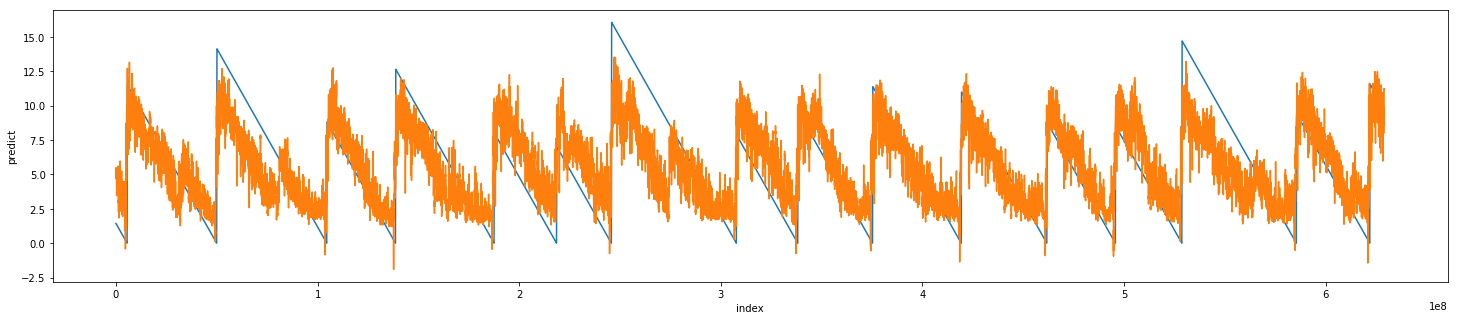

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[146]['df_valid_pred']
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_valid_pred['index'], y=df_valid_pred.predict)

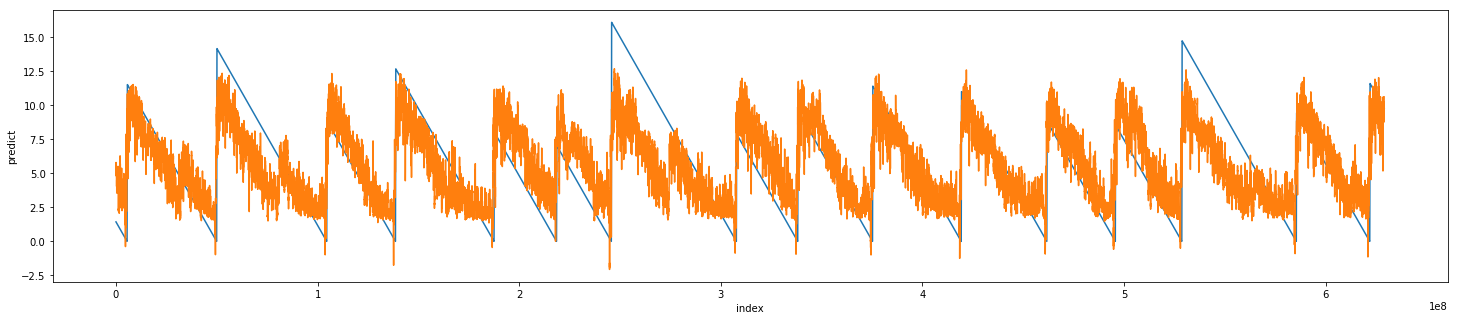

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[865]['df_valid_pred']
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_valid_pred['index'], y=df_valid_pred.predict)

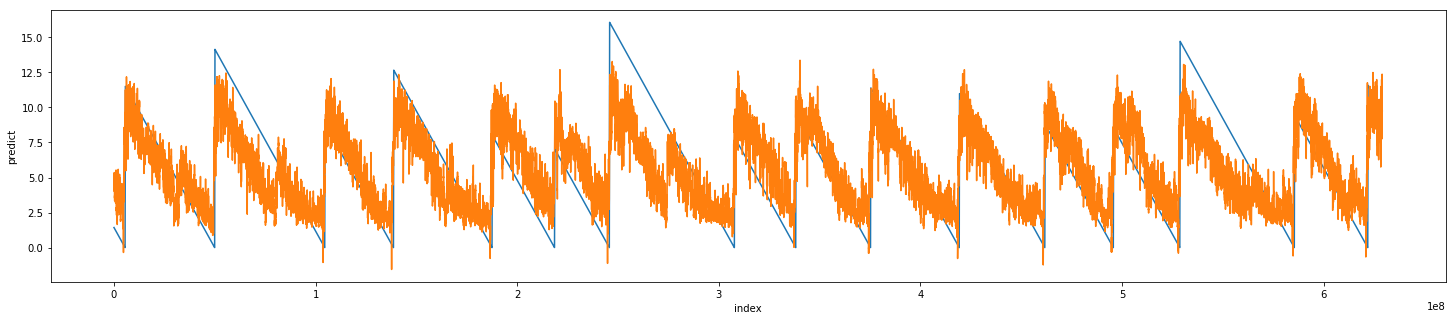

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
df_valid_pred = df_trial.loc[903]['df_valid_pred'].sort_values(by=['index'])
sns.lineplot(x=df_train['index'], y=df_train.y)
sns.lineplot(x=df_train['index'], y=df_valid_pred.predict)

In [131]:
set(columns146+columns474+columns294)

{'5000crest_factor_quantile75',
 '5000quantile99quantile05',
 '5000smoothness_entropy_',
 '5000smoothness_quantile25',
 '5000smoothness_std_',
 '5000std_quantile05',
 'FFT_Mag_75q0',
 'Hilbert_mean_2',
 'MA_1000MA_std_mean_7',
 'abs_max_1',
 'abs_max_4',
 'abs_max_roll_mean_1000',
 'abs_q01_4',
 'abs_q01_6',
 'abs_q05_2',
 'abs_q05_6',
 'abs_q25_5',
 'abs_q75_6',
 'abs_q75_7',
 'abs_q95_2',
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'iqr',
 'iqr_6',
 'median__roll_std',
 'min_roll_std_100',
 "number_crossing_m{'m': 1}",
 "number_peaks{'n': 10}",
 "number_peaks{'n': 5}",
 'partial_autocorrelationlag_5',
 'q01_2',
 'q05_5',
 'q05_roll_std_100',
 'q05_roll_std_1000',
 'q25_roll_std_100',
 'q75_roll_mean_10',
 'spkt_welch_density__coeff_20',
 'spkt_welch_density__coeff_25',
 'spkt_welch_density__coeff_28',
 'spkt_welch_density__coeff_3',
 'spkt_welch_density__coeff_4',
 'spkt_welch_densitycoeff_2',
 'spkt_welch

In [138]:
columns_ = columns146+columns474+columns294
common_columns = []
for col in list(set(columns_)):
    if(columns_.count(col)==3):
        common_columns.append(col)

In [139]:
common_columns

['q05_roll_std_1000',
 'abs_q25_5',
 'spkt_welch_density__coeff_4',
 'spkt_welch_density__coeff_3',
 'q05_roll_std_100',
 'abs_q01_4',
 'q25_roll_std_100',
 "number_peaks{'n': 10}",
 'spkt_welch_densitycoeff_2']

In [172]:
common_columns = []
columns_ = ['q05_roll_std_1000',
 'abs_q25_5',
 'spkt_welch_density__coeff_4',
 'spkt_welch_density__coeff_3',
 'q05_roll_std_100',
 'abs_q01_4',
 'q25_roll_std_100',
 "number_peaks{'n': 10}",
 'spkt_welch_densitycoeff_2']+['abs_q01_4',
 'spkt_welch_density__coeff_3',
 'abs_q75_7',
 'q05_roll_std_1000',
 'q25_roll_std_100',
 "number_peaks{'n': 10}",
 'spkt_welch_densitycoeff_2',
 'abs_max_7']
for col in list(set(columns_)):
    if(columns_.count(col)==2):
        common_columns.append(col)

In [136]:
len(['3th_peak_freq',
 '5000clearance_factor_quantile25',
 '5000clearance_factor_quantile75',
 '5000crest_factor_quantile75',
 '5000no_zero_crossing_mean_',
 '5000quantile99median_',
 '5000quantile99quantile05',
 '5000smoothness_entropy_',
 '5000smoothness_quantile25',
 '5000smoothness_std_',
 '5000std_quantile05',
 'FFT_Mag_75q0',
 'FFT_Mag_95q0',
 'Hilbert_mean_2',
 'Hilbert_mean_6',
 'MA_1000MA_std_mean_7',
 'abs_max_1',
 'abs_max_3',
 'abs_max_4',
 'abs_max_5',
 'abs_max_7',
 'abs_max_8',
 'abs_max_roll_mean_1000',
 'abs_q01_4',
 'abs_q01_6',
 'abs_q05_2',
 'abs_q05_6',
 'abs_q05_7',
 'abs_q25_5',
 'abs_q75_6',
 'abs_q75_7',
 'abs_q95_2',
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 'ar_coefficientk_10__coeff_0',
 "autocorrelation{'lag': 5}",
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'iqr',
 'iqr_6',
 'kurt_1',
 'kurt_2',
 'max_to_min_diff_5',
 'median__roll_std',
 'min_roll_std_100',
 "number_crossing_m{'m': 1}",
 "number_peaks{'n': 10}",
 "number_peaks{'n': 5}",
 'partial_autocorrelationlag_5',
 'peak_to_average_power_ratio__roll_mean',
 'q01_2',
 'q01_roll_std_10',
 'q01_roll_std_1000',
 'q05_5',
 'q05_roll_std_10',
 'q05_roll_std_100',
 'q05_roll_std_1000',
 'q25_roll_std_100',
 'q75_roll_mean_10',
 "quantile{'q': 0.2}",
 'spkt_welch_density__coeff_20',
 'spkt_welch_density__coeff_25',
 'spkt_welch_density__coeff_28',
 'spkt_welch_density__coeff_3',
 'spkt_welch_density__coeff_4',
 'spkt_welch_density__coeff_42',
 'spkt_welch_densitycoeff_2',
 'spkt_welch_densitycoeff_8'])

66